## edgeR-TMM normalization with miRNA counts table

https://www.bioconductor.org/packages/release/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf

In [1]:
options(stringsAsFactors = FALSE)

Load required libraries (install packages if required)

In [2]:
#Load packages
library(limma)
library(edgeR)
library(data.table)
library(RColorBrewer)
library(gplots)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




### Creating DGE object for edgeR

Read in counts file and view head of file

In [3]:
#Read file
counts <- read.csv("data/Serum_ExoR_Nor_miRNA_counts.csv", stringsAsFactors=F, row.names=1)
head(counts)

,ExoRNeasy1_1,ExoRNeasy2_2,ExoRNeasy3_3,ExoRNeasy1_145,Nor1,Nor2,Nor3
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
hsa-miR-122-5p,2160,3274,3310,1986,95981,85210,358012
hsa-miR-486-5p,27142,39637,49572,26038,44072,40849,163263
hsa-miR-92a-3p,31034,46010,56577,18258,44786,30294,71414
hsa-miR-21-5p,143470,266112,277497,82365,88485,83749,145037
hsa-miR-423-5p,32979,51863,65891,28585,30736,33077,103540
hsa-let-7b-5p,60058,78710,112326,46062,41143,49977,55042


Make DGE object: Define groups and design

In [4]:
#Define groups and make DGE object 
group<-as.factor(c("ExoR","ExoR","ExoR","ExoR","Nor","Nor","Nor"))
group
design <- model.matrix(~0+group)
dge<- DGEList(counts=counts,group=group)

[1] ExoR ExoR ExoR ExoR Nor  Nor  Nor 
Levels: ExoR Nor

Plot library sizes

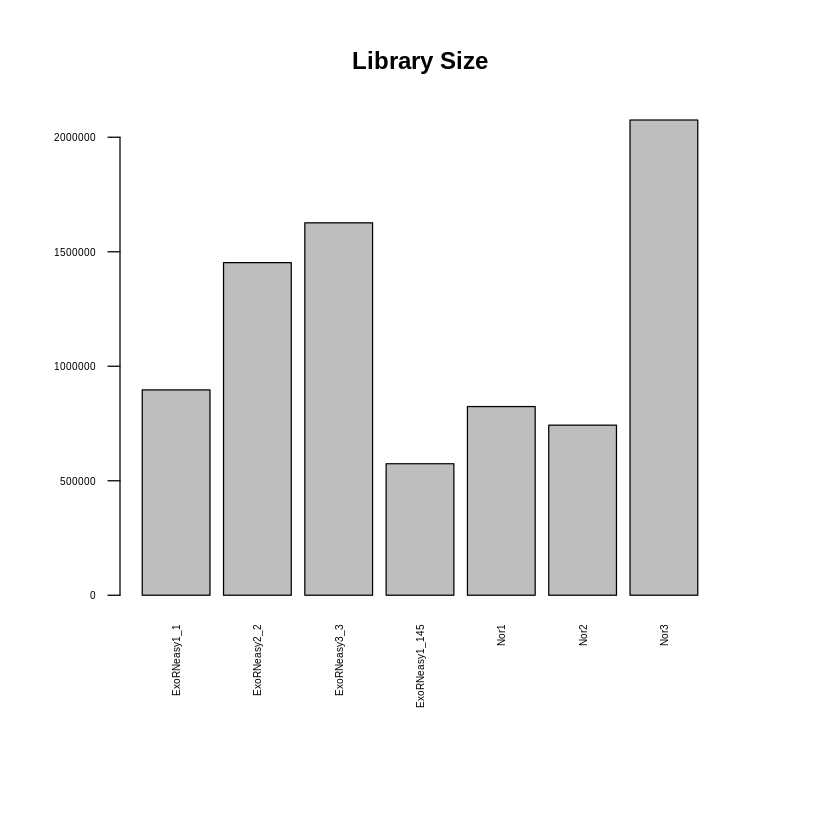

In [5]:
par(mar=c(10,5,5,5))
options(scipen=5)
barplot(dge$samples$lib.size, horiz=F, names.arg=colnames(dge$counts), las=2, cex.name = 0.5, cex.axis=.5, main="Library Size")

In [6]:
#To check
class(dge)
dim(dge)
dge$samples

[1] "DGEList"
attr(,"package")
[1] "edgeR"

[1] 1826    7

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
ExoRNeasy1_1,ExoR,896744,1
ExoRNeasy2_2,ExoR,1452574,1
ExoRNeasy3_3,ExoR,1626310,1
ExoRNeasy1_145,ExoR,574327,1
Nor1,Nor,823880,1
Nor2,Nor,742767,1
Nor3,Nor,2075355,1


### Filtering based on cpm cutoff

In [7]:
#filter- miRNAs with at least 12 cpm present in at least 2 samples
table(rowSums(dge$counts==0)==7)
keep <- rowSums(cpm(dge)>12) >= 2
dge.f <- dge[keep, , keep.lib.sizes=FALSE]
dim(dge.f)


FALSE  TRUE 
  809  1017 

[1] 419   7

### Estimate dispersion
Estimate dispersion
The square root of the common dispersion gives the coefficient of variation of biological variation. Here the common dispersion is found to be 0.92, so the coefficient of biological variation (BCV) is around 0.96. 

In [8]:
#estimate dispersions
d <- estimateDisp(dge.f, design=design)
d$common.dispersion
sqrt(d$common.disp)

[1] 0.9218521

[1] 0.9601313

### Normalization using TMM
“TMM (weighted trimmed mean of log expression) determines scaling factor calculated after double trimming values at the two extremes based on log-intensity ratios (M-values) and log-intensity averages (A-values)” (Dillies et al. Briefings in Bioinformatics, Vol. 14 (6): 671–683, 2013)

In [9]:
#TMM
TMM <- calcNormFactors(d, method="TMM")
TMM <- estimateCommonDisp(TMM)
TMM <- exactTest(TMM)
table(p.adjust(TMM$table$PValue, method="BH")<0.05)
TMM.table<-data.frame(topTags(TMM,n=61))
write.table(TMM.table,file="edgeR_TMM_p0.05.txt",sep="\t")


FALSE  TRUE 
  358    61 

## Plots

Calculate log cpm to plot graphs using TMM normalized counts

In [10]:
#cpm, log cpm using TMM
cpm <- cpm(dge)
lcpm <- cpm(dge, log=TRUE)
dge.norm <- calcNormFactors(dge.f,method="TMM") 
dge.norm$samples$norm.factors
lcpm.norm <- cpm(dge.norm, log=TRUE)

[1] 1.0113710 1.0049834 0.9919675 1.0690993 0.9809371 1.0490079 0.9015612

### Raw and unfiltered data

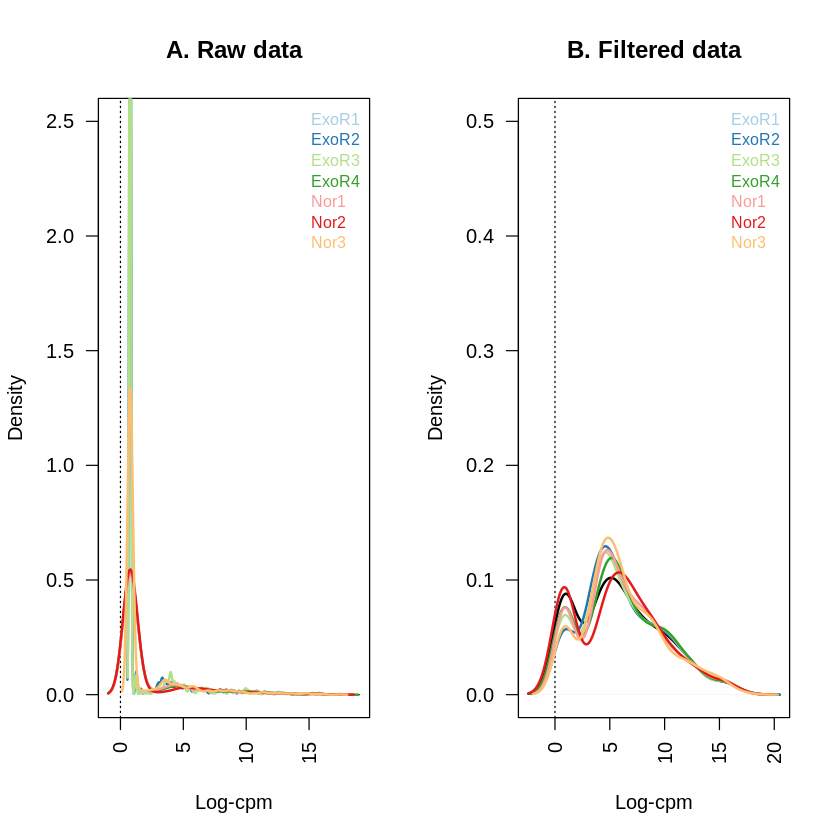

In [11]:
#set colours for graphs
nsamples <- ncol(dge)
nsamples<-(dge.f)
nsamples<-ncol(dge.norm)
col <- brewer.pal(nsamples, "Paired")

#Visualise filtered vs unfiltered data
#plot unfiltered data
samplenames<-c("ExoR1","ExoR2","ExoR3","ExoR4","Nor1","Nor2","Nor3")
par(mfrow=c(1,2))
plot(density(lcpm[,1]),col=col(lcpm,as.factor = FALSE),lwd=1,ylim=c(0,2.5),las=2,main="",xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=0, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n",cex=0.8,pt.cex=0.8)

#plot filtered data
lcpm.f <- cpm(dge.f, log=TRUE)
plot(density(lcpm.f[,1]), col=col(lcpm.f,as.factor=FALSE), lwd=2, ylim=c(0,0.5), las=2,
     main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=0, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm.f[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n",cex=0.8,pt.cex=0.8)

### Boxplots of TMM-Normalized vs. unnormalized data

[1] 1 1 1 1 1 1 1

[1] 1.0113710 1.0049834 0.9919675 1.0690993 0.9809371 1.0490079 0.9015612

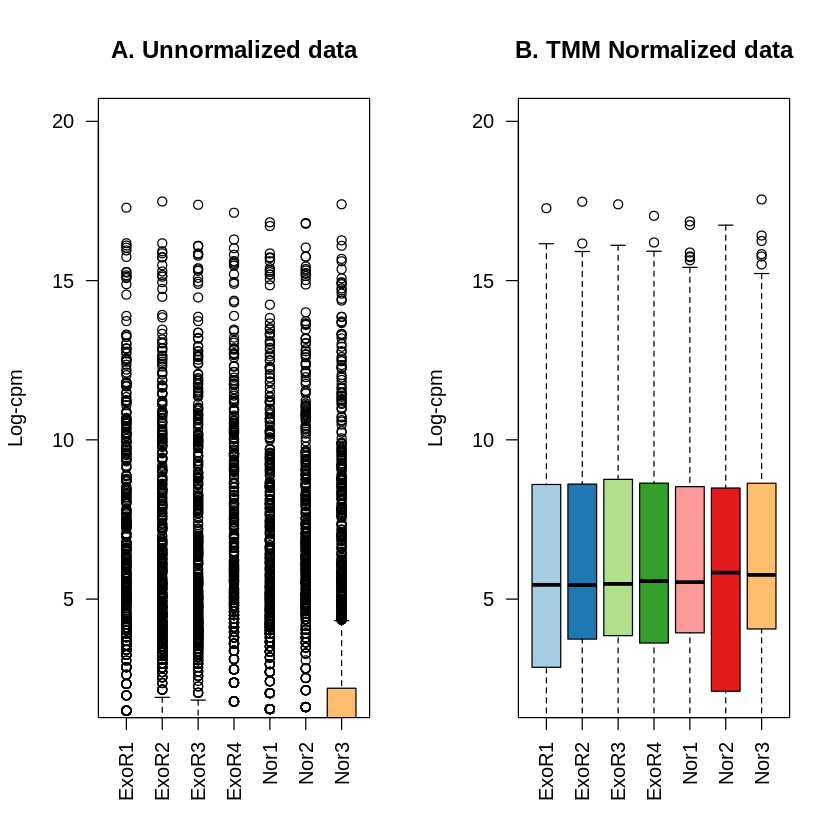

In [12]:
#Visualise normalised data
par(mfrow=c(1,2))
lcpm <- cpm(dge, log=TRUE)
dge$samples$norm.factors
boxplot(lcpm,las=2, col=col, main="",ylim=c(2,20),names=c("ExoR1","ExoR2","ExoR3","ExoR4","Nor1","Nor2","Nor3"))
title(main="A. Unnormalized data",ylab="Log-cpm")

dge.norm$samples$norm.factors
lcpm.norm <- cpm(dge.norm, log=TRUE)
boxplot(lcpm.norm, las=2, col=col, main="", ylim=c(2,20),names=c("ExoR1","ExoR2","ExoR3","ExoR4","Nor1","Nor2","Nor3"))
title(main="B. TMM Normalized data",ylab="Log-cpm")

### PCA plot

Warning message in brewer.pal(nlevels(col.group), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


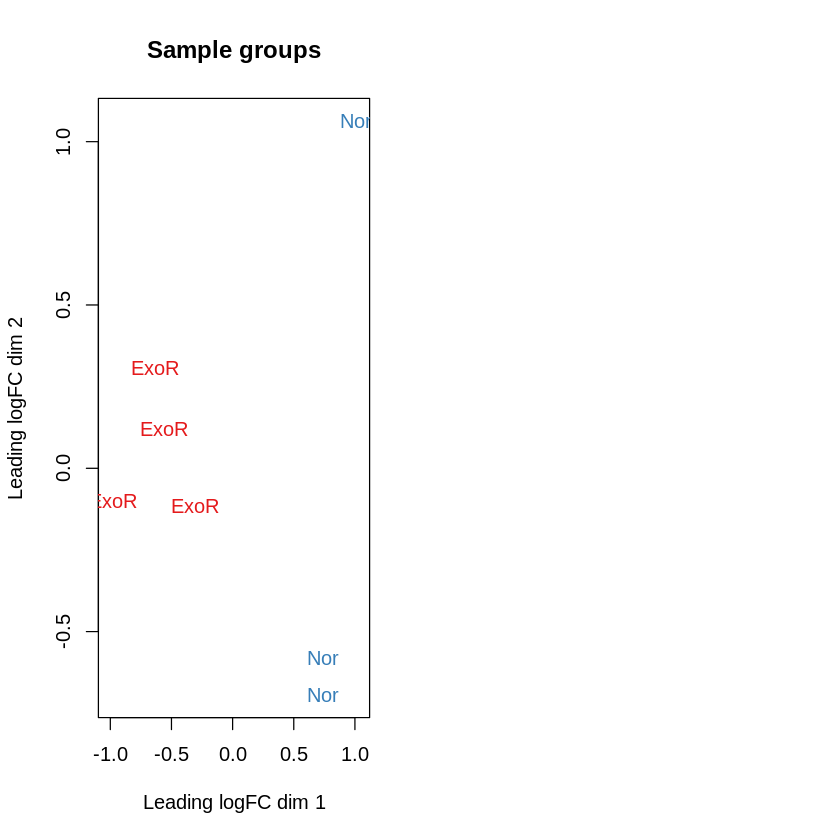

In [13]:
#MDS plot PCA
par(mfrow=c(1,2))
col.group <- group
levels(col.group) <- brewer.pal(nlevels(col.group), "Set1")
col.group <- as.character(col.group)
plotMDS(lcpm.norm, labels=group, col=col.group)
title(main="Sample groups")

### Heatmap of miRNAs significantly different between groups

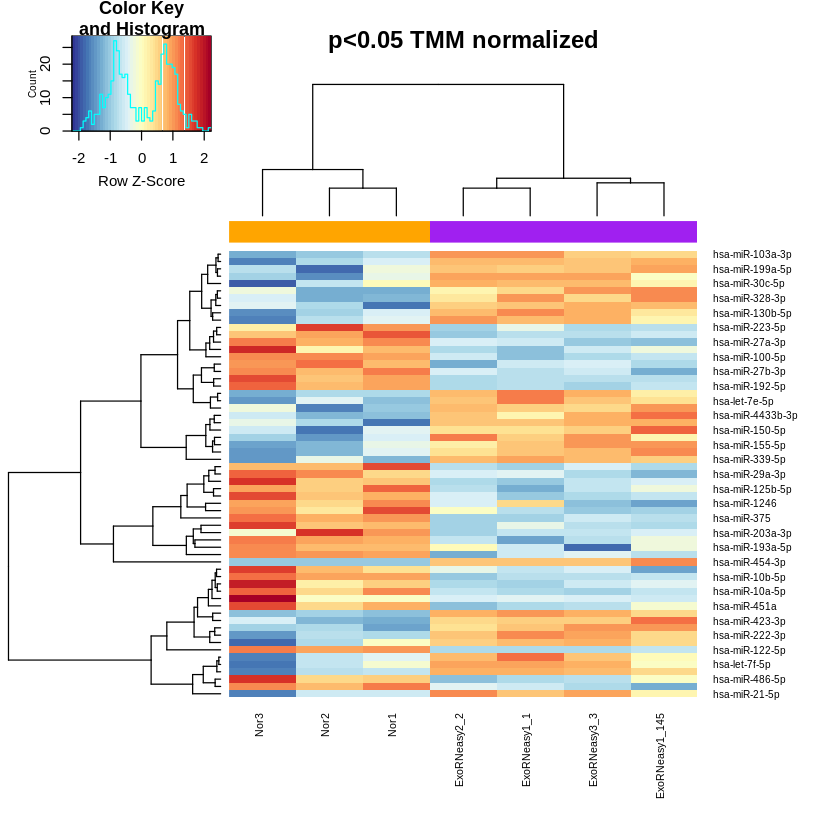

In [14]:
#heatmap
#subset miRNAs from lcpm normalized data
miRNAs<-as.list(row.names(TMM.table))
miRNAs_lcpm.norm<-subset(lcpm.norm,rownames(lcpm.norm) %in% miRNAs)

## Get some nicer colours
mypalette <- brewer.pal(11,"RdYlBu")
morecols <- colorRampPalette(mypalette)
# Set up colour vector for celltype variable
col.cell <- c("purple","orange")[group]

heatmap.2(miRNAs_lcpm.norm,col=rev(morecols(50)),trace="none", main="p<0.05 TMM normalized",ColSideColors=col.cell,scale="row",margins=c(9,9), cexCol=0.8)
